[Reference: Novel indexes for diagnosing metabolic syndrome in apparently healthy Gujarati Asian Indians: a cross-sectional study](https://academic.oup.com/qjmed/article/109/11/717/2631720?login=false)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd

In [2]:
def compute_z_score(x, params):
    return (x-params[0])/params[1]

In [49]:
def compute_percentiles(func, params, patient_details, plabel, nlabel, visualise, savefig):
    
    score = func(patient_details)
    sex = patient_details['sex']
    percentiles = [norm.cdf(score, params[sex][x][0], params[sex][x][1])*100 for x in ['MetSN', 'MetSP']]
    
    if(visualise):
        metsn_params = params[sex]['MetSN']
        metsp_params = params[sex]['MetSP']
                
        plt.figure(figsize=(14,5))
        
        ### Fix the axis to [-4,4]
        z_score = compute_z_score(score, metsn_params)
        # Bound the z_score values to be between -4 to 4
        if(z_score>4): z_score = 4
        elif(z_score<-4): z_score = -4
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
#         r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-4, 4, 100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,1)
        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(plabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-4,5)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        z_score = compute_z_score(score, metsp_params)
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-4, 4, 100)
        y1 = norm.pdf(x1, 0,1)
        
        plt.subplot(1,2,2)
        plt.plot(x1, y1, color='red')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(nlabel)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-4,5)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
                
        if(savefig): plt.savefig(f"./Patients/{patient_details['id']}/{patient_details['id']}_{func.__name__}.png")
        plt.show()
        
    return score, percentiles

# LAP

#### Formulae

Males: (WC (cm) - 65) × (TG (mmol/l))

Females: (WC (cm) - 58) × (TG (mmol/l))

In [4]:
LAP_params = {
                    'M': {'MetSN': [16.48, 10.95], 'MetSP': [36.11, 19.9]},
                    'F': {'MetSN': [16.01, 10.143], 'MetSP': [34.69, 19.34]}
            }

In [5]:
# wc(cm), TG(mg/dl)
def LAP(patient):
    sex, WC , TG = patient['sex'], patient['WC'], patient['TG']
    if (sex == 'M'):
        return min(100,((WC-65)*(TG/88.57))*(100/160))
    elif (sex == 'F'):
        return min(100,((WC-58)*(TG/88.57))*(100/160))

# VAI

### Formulae

**Males:** VAI=(WC/(39.69+(1.88×BMI)))×(TG/0.03)×(1.31/HDL)

**Females:** VAI(WC/(36.58+(1.89×BMI)))×(TG/0.81)×(1.52/HDL)

In [6]:
VAI_params = {
                    'M': {'MetSN': [14.59, 2.35], 'MetSP': [30.82, 18.24]},
                    'F': {'MetSN': [15.18, 4.71], 'MetSP': [31.53, 21.18]}
            }

In [7]:
# WC(cm), BMI(kg/m2), TG(mmol/L), HDL(mmol/L)
def VAI(patient):
    sex, WC, BMI, TG, HDL = patient['sex'], patient['WC'], patient['BMI'], patient['TG'], patient['HDL']
    if (sex == 'M'):
        return min(100,((WC/(39.69+(1.88*BMI)))*(TG/(88.57*1.03))*((1.31*38.67)/HDL))*(100/8.5))
    elif (sex == 'F'):
        return min(100,((WC/(36.58+(1.89*BMI)))*(TG/(88.57*0.81))*((1.52*38.67)/HDL))*(100/8.5))

# Diabetes Score 1

In [8]:
Diabetes1_params = {
                    'M': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]},
                    'F': {'MetSN': [17.79, 5.86], 'MetSP': [46.4, 17.86]}
            }

In [9]:
def compute_age_factor_A(BMI, age):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return -0.0002409*(age**3) +0.035989*(age**2)-1.2938*age +15.9448
    elif(BMI>=36): return -0.00018165*(age**3) +0.026829*(age**2)-0.88434*age +9.7043
    elif(BMI>=34): return -9.02e-05*(age**3) +0.014945*(age**2)-0.44345*age +4.9542
    elif(BMI>=32): return -0.00015453*(age**3) +0.024283*(age**2)-0.89484*age +10.4953
    elif(BMI>=30): return -0.00014778*(age**3) +0.023199*(age**2)-0.88224*age +10.346
    elif(BMI>=28): return -0.0001085*(age**3) +0.017384*(age**2)-0.6534*age +7.1327
    elif(BMI>=26): return -6.576e-05*(age**3) +0.011355*(age**2)-0.44233*age +5.225
    elif(BMI>=24): return -3.9578e-05*(age**3) +0.0075099*(age**2)-0.31027*age +3.7777
    elif(BMI>=22): return -1.5022e-05*(age**3) +0.0038618*(age**2)-0.16786*age +2.0549
    elif(BMI>=20): return 0.0016166*(age**2)-0.089607*age +1.2032
    elif(BMI>=18.5): return 0.00093971*(age**2)-0.042102*age +0.57713

In [10]:
def Diabetes1(patient):
    sex, age, glu, TG, BMI = patient['sex'], patient['age'], patient['glu'], patient['TG'], patient['BMI']
    age_factor = compute_age_factor_A(BMI, age)
    return (math.log((1+((glu/80)*(TG/80)*(BMI/22)))*(1+(age_factor/100))))*25

# Diabetes Score 2

In [11]:
Diabetes2_params = {
                    'M': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]},
                    'F': {'MetSN': [17.03, 7.52], 'MetSP': [42.89, 13.21]}
            }

In [12]:
def compute_age_factor_B(BMI):
    if(BMI > 40 or BMI < 18.5): return 0 # WHAT TO DO IN THIS CASE?
    if(BMI>=38): return 19.74
    elif(BMI>=36): return 17.75
    elif(BMI>=34): return 20.28
    elif(BMI>=32): return 15.21
    elif(BMI>=30): return 12.58
    elif(BMI>=28): return 10.62
    elif(BMI>=26): return 9.44
    elif(BMI>=24): return 7.75
    elif(BMI>=22): return 7.11
    elif(BMI>=20): return 6.02
    elif(BMI>=18.5): return 4.27

In [13]:
def Diabetes2(patient):
    sex, age, glu, TG, BMI = patient['sex'],patient['age'],patient['glu'],patient['TG'],patient['BMI']
    age_factor_A = compute_age_factor_A(BMI, age)
    age_factor_B = compute_age_factor_B(BMI)
    age_factor = (age_factor_A/age_factor_B)/10
    return 6.6667*((math.log(glu*TG/2))*(1+BMI/40)*(1+age_factor))-66.667

# NAFLD

In [14]:
NAFLD_params = {
                    'M': {'MetSN': [20.47, 8.76], 'MetSP': [55.21, 16.04]},
                    'F': {'MetSN': [20.47, 8.76], 'MetSP': [55.21, 16.04]}
            }

In [15]:
def TG_factor_score(TG):
    if(TG>400): return 3
    elif(TG>50): return 0.0085714*TG-0.42857
    else: return 0

def HOMA_IR_factor_score(HOMA_IR):
    if(HOMA_IR>6): return 3
    elif(HOMA_IR>0.5): return 0.54545*HOMA_IR-0.27273
    else: return 0

def GGT_factor_score(GGT):
    if(GGT>60): return 3
    elif(GGT>20): return 0.075*GGT-1.5
    else: return 0

def ALT_AST_factor_score(ALT_AST):
    if(ALT_AST>1.5): return 3
    elif(ALT_AST>0.95): return 5.4545*ALT_AST-5.1818
    else: return 0

def Uric_acid_factor_score(Uric_acid):
    if(Uric_acid>450): return 3
    elif(Uric_acid>250): return 0.015*Uric_acid-3.75
    else: return 0

In [16]:
def compute_nafld_factor_scores(patient_details):
    TG, HOMA_IR, GGT, ALT_AST, Uric_acid = patient_details
    nafld_factor_scores = []
    nafld_factor_scores.append(TG_factor_score(TG))
    nafld_factor_scores.append(HOMA_IR_factor_score(HOMA_IR))
    nafld_factor_scores.append(GGT_factor_score(GGT))
    nafld_factor_scores.append(ALT_AST_factor_score(ALT_AST))
    nafld_factor_scores.append(Uric_acid_factor_score(Uric_acid))
    return nafld_factor_scores

In [17]:
def NAFLD(patient):
    NRS_TG, NRS_HOMA_IR, NRS_GGT, NRS_ALT_AST, NRS_Uric_acid = compute_nafld_factor_scores([patient['TG'], patient['HOMA_IR'], patient['GGT'], patient['ALT']/patient['AST'], patient['Uric_acid']])
    return (NRS_TG + NRS_HOMA_IR + 2*NRS_GGT + 2*NRS_ALT_AST + NRS_Uric_acid)*(100/21)

# Cardiac Risk Score

In [18]:
Cardiac_params = {
    'M': {'MetSN': [32.85, 14.35], 'MetSP': [55.66, 17.92]},
    'F': {'MetSN': [32.85, 14.35], 'MetSP': [55.66, 17.92]}
}

In [19]:
def TG_HDL_factor_score(TG, HDL):
    TG_HDL = TG/HDL
    if(TG_HDL>10): return 3
    elif(TG_HDL>0.9):return 0.3297*(TG_HDL) - 0.2967
    else: return 0

def TC_HDL_factor_score(TC, HDL):
    TC_HDL = TC/HDL
    if(TC_HDL>8): return 3
    elif(TC_HDL>1.5): return 0.4615*(TC_HDL)-0.6923
    else: return 0

def LDL_HDL_factor_score(LDL, HDL):
    LDL_HDL = LDL/HDL
    if(LDL_HDL>6): return 3
    if(LDL_HDL>0.9): return 0.5882*(LDL_HDL) - 0.5294
    else: return 0

In [20]:
def compute_cardiac_factor_scores(patient_details):
    TG, TC, LDL, HDL = patient_details
    cardiac_factor_scores = []
    cardiac_factor_scores.append(TG_HDL_factor_score(TG,HDL))
    cardiac_factor_scores.append(TC_HDL_factor_score(TC, HDL))
    cardiac_factor_scores.append(LDL_HDL_factor_score(LDL, HDL))
    return cardiac_factor_scores

In [21]:
def Cardiac(patient):
    CRS_TG_HDL, CRS_TC_HDL, CRS_LDL_HDL = compute_cardiac_factor_scores([patient['TG'], patient['TC'], patient['LDL'], patient['HDL']])
    return (math.log(CRS_TG_HDL + CRS_TC_HDL + CRS_LDL_HDL))*(100/2.3)

# Dyslipidemia

In [22]:
def Dyslipidemia(patient, visualise = True, savefig = False):
    TG, TC, HDL, LDL, patient_id = patient['TG'],patient['TC'],patient['HDL'],patient['LDL'], patient['id']
    score = min((math.log10(1+((TG/80)*(TC/150)*(LDL/80)*(50/HDL))))*(100/3), 100)
    
    
    if(visualise):
        z_score = compute_z_score(score, [38,18])
        x = [z_score]*2
        y = [0, norm.pdf(z_score, 0, 1)]
        r = max(3, math.ceil(abs(z_score)))
        x1 = np.linspace(-r, r, r*100)
        y1 = norm.pdf(x1, 0,1)

        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(f"Dyslipidemia Score Distribution")
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)
        
        if(savefig): plt.savefig(f'./Patients/{patient_id}/{patient_id}_Dyslipidemia.png')
        plt.show()
    
    return score

# Hypertension Score

In [23]:
def age_gender_effect(sex, age):
    if(sex == 'M'): return 1+0.25*((0.7304*age+3.6894)/100)
    else: return 1+0.25*((0.9452*age-12.971)/100)
    
def uric_acid_effect(sex, Uric_acid):
    if(sex == 'M' or (sex == 'F' and Uric_acid <= 339)): return 1
    else: return 1+0.5*((0.0541*Uric_acid - 10.811)/100)

In [24]:
def Hypertension(patient):
    sex, age, Uric_acid, SBP, DBP = patient['sex'], patient['age'], patient['Uric_acid'], patient['SBP'], patient['DBP']
    MAP = (SBP+2*DBP)/3
    Anthro_effect = age_gender_effect(sex, age)*uric_acid_effect(sex, Uric_acid)
    
    return 90.909*((MAP/73)*Anthro_effect -1)

In [25]:
def obtain_SBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [137.2,21.4]
        elif(age>=65): return [136.5, 20.4]
        elif(age>=55): return [134.1, 19.5]
        elif(age>=45): return [130.2, 18.2]
        elif(age>=20): return [124.1, 15.1]
        elif(age>=18): return [121.4, 15]
    elif(sex == 'F'):
        if(age>=75): return [136, 22.7]
        elif(age>=65): return [136, 21.2]
        elif(age>=55): return [132.4, 19.3]
        elif(age>=45): return [126.7, 18]
        elif(age>=20): return [115.6, 15]
        elif(age>=18): return [111.4, 12.4]

In [26]:
def obtain_DBP_params(sex, age):
    if(sex == 'M'):
        if(age>=75): return [80.1, 12.4]
        elif(age>=65): return [81.8, 11.9]
        elif(age>=55): return [82.9, 11.6]
        elif(age>=45): return [83.2, 11.7]
        elif(age>=20): return [79.6, 10.9]
        elif(age>=18): return [78.4, 11]
    elif(sex=='F'):
        if(age>=75): return [80.6, 12.9]
        elif(age>=65): return [80.8, 11.9]
        elif(age>=55): return [81.1, 11]
        elif(age>=45): return [80.3, 10.9]
        elif(age>=20): return [75.1, 10.4]
        elif(age>=18): return [71.9, 9.6]

In [51]:
def plot_distributions(patient_id,savefig, z_score1,  title1, z_score2=-1, title2='None'):
    
    plt.figure(figsize=(14,5))

    z_score = z_score1
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)
    
    if not(z_score == -1):
        plt.subplot(1,2,1)
    plt.plot(x1, y1, color='blue')
    plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
    plt.title(title1)
    plt.xlabel("Z-score")
    plt.xticks([x for x in range(-r,r+1)])
    if z_score < 0:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
    else:
        plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
    plt.ylim(0, norm.pdf(0,0,1)*1.15)

    z_score = z_score2
    x = [z_score]*2
    y = [0, norm.pdf(z_score, 0, 1)]
    r = max(3, math.ceil(abs(z_score)))
    x1 = np.linspace(-r, r, r*100)
    y1 = norm.pdf(x1, 0,1)
    
    if not(z_score == -1):
        plt.subplot(1,2,2)
        plt.plot(x1, y1, color='blue')
        plt.plot(x,y,'go--', label = f"LAP = {round(norm.cdf(z_score,0,1),2)}th")
        plt.title(title2)
        plt.xlabel("Z-score")
        plt.xticks([x for x in range(-r,r+1)])
        if z_score < 0:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02), ha='right',fontsize=14,color='green')
        else:
            plt.annotate(f"p{int(round(norm.cdf(z_score,0,1)*100,0))}",(z_score, norm.pdf(z_score,0,1) + 0.02),fontsize=14,color='green')
        plt.ylim(0, norm.pdf(0,0,1)*1.15)

    if(savefig):
        if(z_score2 == -1): plt.savefig(f'./Patients/{patient_id}/{patient_id}_TSH.png')
        else: plt.savefig(f'./Patients/{patient_id}/{patient_id}_SBP-DBP.png')
    plt.show()

In [28]:
def plot_SBP_DBP_distribution(patient, savefig):
    
    sex, age, SBP, DBP, patient_id = patient['sex'],patient['age'],patient['SBP'],patient['DBP'], patient['id']
    
    if(age>=75): age_grp = ">=75"
    elif(age>=65): age_grp = "65-74"
    elif(age>=55): age_grp = "55-64"
    elif(age>=45): age_grp = "45-54"
    elif(age>=20): age_grp = "20-44"
    elif(age>=18): age_grp = "18-19"

    z_score1 = compute_z_score(SBP, obtain_SBP_params(sex, age))
    title1 = f"SBP Distribution, Age: {age_grp}, {sex}"
    z_score2 = compute_z_score(DBP, obtain_DBP_params(sex, age))
    title2 = f"DBP Distribution, Age: {age_grp}, {sex}"
    plot_distributions(patient_id, savefig, z_score1, title1, z_score2, title2)

## Hypothyroidism Score

In [29]:
def Hypothyroidism(patient):
    Diabetes_score_1 = Diabetes1(patient)
    Dyslipidemia_score = Dyslipidemia(patient, False)
    sex, TSH = patient['sex'], patient['TSH']
    if(sex == 'M'):
        return (TSH*(1+0.25*(Diabetes_score_1/100)+0.25*(Dyslipidemia_score/100)))*(100/27)
    if(sex == 'F'):
        return (TSH*(1+0.25*(Diabetes_score_1/100)+0.25*(Dyslipidemia_score/100)))*(100/34)

In [30]:
def plot_TSH_distribution(patient, savefig):
    
    sex, TSH, patient_id = patient['sex'],patient['TSH'], patient['id']
    if(sex == 'M'):
        z_score1 = compute_z_score(TSH, [9.75,6.58])
    else:
        z_score1 = compute_z_score(TSH, [11.46,8.36])
    title1 = f"TSH Distribution ({sex})"
    plot_distributions(patient_id, savefig, z_score1, title1)

## PCOD Score

In [31]:
def PCOD(patient):
    sex = patient['sex']
    if(sex == 'F'):
        BT, LH_FSH, HOMA_IR = patient['BT'], patient['LH_FSH'], patient['HOMA_IR']
        pcod_score = min(100,math.log((BT/0.08)*((LH_FSH**2)/0.025)*(1+(0.25*(HOMA_IR/12))))*(10))
        return pcod_score
    else:
        return -1

In [32]:
PCOD_params = {
    'F': {'MetSN': [43.12, 10.59], 'MetSP': [66.6, 15.8]}
}

## Lifestyle Scoring

In [33]:
class Question():
    def __init__(self, title, options):
        self.title = title
        self.options = options
    
    def get_option(self,marked):
        idx = ord(marked.upper()) - ord('A')
        return self.options[idx]
    
    def get_score(self, marked_option, scores):
        idx = ord(marked_option.upper()) - ord('A')
        return scores[idx]

In [34]:
ques = []
ques.append(Question('Good quality sleep', ['A) Between 7 to 9 hours per night', 'B) Between 5 to 6 hours per night', 'C) ≤4 or ≥9 hours per night']))
ques.append(Question('Sedentary time', ['A) <1 hour per day', 'B) ≥1 and <4 hours per day', 'C) >4 hours per day']))
ques.append(Question('Diet diversity', ['A) >3 food groups per day', 'B) < 3 food groups per day']))
ques.append(Question('Physical activity', ['A) ≥60 mins per day', 'B) ≥30 mins per day', 'C) <30 mins or none per day']))
ques.append(Question('Fruit intake', ['A) 1-2 per day', 'B) ≤2 to 3 times a week', 'C) Once a week or less']))

ques.append(Question('Legume consumption', ['A) Everyday', 'B) Every alternate day', 'C) Not Frequent']))
ques.append(Question('Alcohol consumption', ['A) <3 units/ week', 'B) ≥3 units / week', 'C) Former drinker', 'D) Do not drink']))
ques.append(Question('Cigarette consumption', ['A) ≤2 days a month', 'B) ≥3 and ≤19 days a month', 'C) ≥20 days a month', 'D) Former smoker', 'E) Do not smoke']))

ques.append(Question('Sugary drinks or beverages', ['A) ≤1 per week', 'B) 2-3 per week', 'C) 4-5 per week', 'D) >=6 per week or >=1 per day']))
ques.append(Question('Breakfast frequency', ['A) More than 5 times a week', 'B) Less than 5 times a week', 'C) Do not have breakfast']))

In [35]:
questions = {}
for question in ques:
    questions[question.title] = question

In [36]:
def NAFLD_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,2,5])
    score += ques['Diet diversity'].get_score(marked['Diet diversity'][0], [0,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,2,5])
    score += ques['Fruit intake'].get_score(marked['Fruit intake'][0], [0,2,5])
    return score*(100/19)

In [37]:
def Hypertension_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Legume consumption'].get_score(marked['Legume consumption'][0], [0,2,5])
    score += ques['Alcohol consumption'].get_score(marked['Alcohol consumption'][0], [2,5,1,0])
    score += ques['Cigarette consumption'].get_score(marked['Cigarette consumption'][0], [0,2,5,1,0])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Diet diversity'].get_score(marked['Diet diversity'][0], [0,2])
    return score*(100/19)

In [38]:
def Diabetes2_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,2,5,5])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,5,10])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,2,5])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,2,5])
    return score*(100/25)

In [39]:
def Obesity_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,2,4])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,1,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,1,2,2])
    return score*(100/12)

In [40]:
def Metabolic_Syndrome_lifestyle_score(patient, ques, marked):
    score = 0
    score += ques['Good quality sleep'].get_score(marked['Good quality sleep'][0], [0,1,2])
    score += ques['Breakfast frequency'].get_score(marked['Breakfast frequency'][0], [0,2,2])
    score += ques['Sedentary time'].get_score(marked['Sedentary time'][0], [0,1,2])
    score += ques['Physical activity'].get_score(marked['Physical activity'][0], [0,1,2])
    score += ques['Sugary drinks or beverages'].get_score(marked['Sugary drinks or beverages'][0], [0,1,1,2])
    if(patient['sex'] == 'M'): score += 1
        
    BMI = patient['BMI']
    if(17 <= BMI < 25): score += 0
    elif(16<= BMI < 17 or 25<=BMI<30): score += 1
    elif(BMI<16 or 30<=BMI<35): score += 2
    else: score += 3
    
    WHtR = patient['WC']/patient['height']
    score += np.sign(WHtR - 0.5) + 1

    return score*(100/16)

In [41]:
questions

{'Good quality sleep': <__main__.Question at 0x1770e4f4040>,
 'Sedentary time': <__main__.Question at 0x1770e4f4d90>,
 'Diet diversity': <__main__.Question at 0x1770e4f4310>,
 'Physical activity': <__main__.Question at 0x1770e4f4d30>,
 'Fruit intake': <__main__.Question at 0x1770e4f4f70>,
 'Legume consumption': <__main__.Question at 0x1770e4f47c0>,
 'Alcohol consumption': <__main__.Question at 0x1770e4f4820>,
 'Cigarette consumption': <__main__.Question at 0x1770e4f4cd0>,
 'Sugary drinks or beverages': <__main__.Question at 0x1770e4f43a0>,
 'Breakfast frequency': <__main__.Question at 0x1770e4f4190>}

In [42]:
def questions_lifestyle_score(questions):
    marked = {}
    print('Evaluating LifeStyle Scores, Please answer the following questions:')
    for title, question in questions.items():
        prompt = question.title + '\n'
        for option in question.options:
            prompt += option + '\n'
        prompt += 'Your choice: '
        marked[title] = question.get_option(input(prompt))
    return marked

### Final Presentation

In [55]:
import os

def generate_comprehensive_report(patient, questions):
    
    p_id = patient['id']
    
    try:
        os.mkdir(f'./patients/{p_id}')
    except:
        pass
    
    # Patient Details
    print(f"Patient Details:")
    df = pd.DataFrame(patient.values(), index = patient.keys())
    df.columns = ['Values']
    display(df)
    
    print('*'*50)
    
    # Ask the questionnaire for evaluating lifestyle scores
    marked = questions_lifestyle_score(questions)
    df = pd.DataFrame(marked.values(), index = marked.keys())
    df.columns = ['Marked Choice']
    display(df)
    
    print('*'*50)
    print('*'*50)
    
    print('Comprehensive Report')
    
    savefig = True
    
    print('Risk Assessment for Obesity:')
    LAP_score, LAP_percentiles = compute_percentiles(LAP, LAP_params, patient, 'Healthy Population', 'Diseased Population', False, False)
    print(f'Obesity Score: {round(LAP_score,2)}')
    print(f'Lifestyle Score: {round(Obesity_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(LAP_percentiles[0], 2)}, Diseased Percentile: {round(LAP_percentiles[1], 2)}')
    print('Obesity Score Distributions:')
    compute_percentiles(LAP, LAP_params, patient, 'Healthy Population', 'Obese Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Metabolic Syndrome:')
    VAI_score, VAI_percentiles = compute_percentiles(VAI, VAI_params, patient, 'Healthy Population', 'Metabolic Syndrome Positive Population', False, False)
    print(f'Metabolic Syndrome Score: {round(VAI_score,2)}')
    print(f'Lifestyle Score: {round(Metabolic_Syndrome_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(VAI_percentiles[0], 2)}th, Diseased Percentile: {round(VAI_percentiles[1], 2)}th')
    print('Metabolic Syndrome Score Distributions:')
    compute_percentiles(VAI, VAI_params, patient, 'Healthy Population', 'Metabolic Syndrome Positive Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Diabetes(Type I):')
    Diabetes1_score, Diabetes1_percentiles = compute_percentiles(Diabetes1, Diabetes1_params, patient, 'Healthy Population', 'Diabetic Population', False, False)
    print(f'Diabetes1 Score: {round(Diabetes1_score,2)}')
    # No lifestyle score
    print(f'Healthy Percentile: {round(Diabetes1_percentiles[0], 2)}th, Diseased Percentile: {round(Diabetes1_percentiles[1], 2)}th')
    print('Diabetes(Type I) Score Distributions:')
    compute_percentiles(Diabetes1, Diabetes1_params, patient, 'Healthy Population', 'Diabetic Population', True, savefig)
    
    print('*'*50)
    
    
    #### Drop Type II
    print('Risk Assessment for Diabetes(Type II):')
    Diabetes2_score, Diabetes2_percentiles = compute_percentiles(Diabetes2, Diabetes2_params, patient, 'Healthy Population', 'Diabetic Population', False, False)
    print(f'Diabetes2 Score: {round(Diabetes2_score,2)}')
    print(f'Lifestyle Score: {round(Diabetes2_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(Diabetes2_percentiles[0], 2)}th, Diseased Percentile: {round(Diabetes2_percentiles[1], 2)}th')
    print('Diabetes(Type II) Score Distributions:')
    compute_percentiles(Diabetes2, Diabetes2_params, patient, 'Healthy Population', 'Diabetic Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for NAFLD:')
    NAFLD_score, NAFLD_percentiles = compute_percentiles(NAFLD, NAFLD_params, patient, 'Healthy Population', 'NAFLD Population', False, False)
    print(f'NAFLD Score: {round(NAFLD_score,2)}')
    print(f'Lifestyle Score: {round(NAFLD_lifestyle_score(patient, questions, marked),2)}')
    print(f'Healthy Percentile: {round(NAFLD_percentiles[0], 2)}th, Diseased Percentile: {round(NAFLD_percentiles[1], 2)}th')
    print('NAFLD Score Distributions:')
    compute_percentiles(NAFLD, NAFLD_params, patient, 'Healthy Population', 'NAFLD Population', True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Cardiac Disease:')
    Cardiac_score, Cardiac_percentiles = compute_percentiles(Cardiac, Cardiac_params, patient, 'Healthy Population', 'Unhealthy Population', False, False)
    print(f'Diabetes1 Score: {round(Cardiac_score,2)}')
    # Lifestyle score?
    print(f'Healthy Percentile: {round(Cardiac_percentiles[0], 2)}th, Diseased Percentile: {round(Cardiac_percentiles[1], 2)}th')
    print('Cardiac Score Distributions:')
    compute_percentiles(Cardiac, Cardiac_params, patient, 'Healthy Population', 'Unhealthy Population', True, savefig)
    
    
    if(patient['sex'] == 'F'):
        print('*'*50)
        print('Risk Assessment for PCOD:')
        PCOD_score, PCOD_percentiles = compute_percentiles(PCOD, PCOD_params, patient, 'Healthy Population', 'PCOD Population', False, False)
        print(f'PCOD Score: {round(PCOD_score,2)}')
        # Lifestyle ?
        print(f'Healthy Percentile: {round(PCOD_percentiles[0], 2)}th, Diseased Percentile: {round(PCOD_percentiles[1], 2)}th')
        print('PCOD score Distributions:')
        compute_percentiles(PCOD, PCOD_params, patient, 'Healthy Population', 'PCOD Population', True, savefig)
    
    
    print('*'*50)
    
    print('Risk Assessment for Hypertension:')
    Hypertension_score = Hypertension(patient)
    print(f'Hypertension Score: {round(Hypertension_score,2)}')
    print(f'Lifestyle Score: {round(Hypertension_lifestyle_score(patient, questions, marked),2)}')
    print('Blood Pressure Distributions:')
    plot_SBP_DBP_distribution(patient, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Dyslipidemia:')
    Dyslipidemia_score = Dyslipidemia(patient, False)
    print(f'Dyslipidemia Score: {round(Dyslipidemia_score,2)}')
    # Lifestyle Score?
    print('Dyslipidemia Score Distributions:')
    Dyslipidemia(patient, True, savefig)
    
    print('*'*50)
    
    print('Risk Assessment for Hypothyroidism:')
    Hypothyroidism_score = Hypothyroidism(patient)
    print(f'Hypothyroidism Score: {round(Hypothyroidism_score,2)}')
    # Lifestyle Score?
    print('TSH Level Distributions:')
    plot_TSH_distribution(patient, savefig)
    
    
    
    print('*'*115)
    print('*'*50,'End Of Report','*'*50)
    print('*'*115)

In [47]:
P_II_14 = {
    'id' : 'II-14',
    'sex' :'M',
    'WC' : 104,
    'TG' : 568,
    'BMI' : 30.03,
    'HDL' : 32.3,
    'age' :59,
   'glu' : 176,
    'HOMA_IR' : 9.99,
    'GGT' : 69,
    'ALT' : 14,
    'AST': 14,
    'Uric_acid': 450,
    'TC' : 281,
    'LDL' : 174,
    'SBP' : 143,
    'DBP': 85,
    'TSH' : 17.53,
    'height':162.9
}

Patient Details:


,Values
id,II-14
sex,M
WC,104
TG,568
BMI,30.03
HDL,32.3
age,59
glu,176
HOMA_IR,9.99
GGT,69


**************************************************
Evaluating LifeStyle Scores, Please answer the following questions:
Good quality sleep
A) Between 7 to 9 hours per night
B) Between 5 to 6 hours per night
C) ≤4 or ≥9 hours per night
Your choice: a
Sedentary time
A) <1 hour per day
B) ≥1 and <4 hours per day
C) >4 hours per day
Your choice: c
Diet diversity
A) >3 food groups per day
B) < 3 food groups per day
Your choice: a
Physical activity
A) ≥60 mins per day
B) ≥30 mins per day
C) <30 mins or none per day
Your choice: c
Fruit intake
A) 1-2 per day
B) ≤2 to 3 times a week
C) Once a week or less
Your choice: c
Legume consumption
A) Everyday
B) Every alternate day
C) Not Frequent
Your choice: a
Alcohol consumption
A) <3 units/ week
B) ≥3 units / week
C) Former drinker
D) Do not drink
Your choice: d
Cigarette consumption
A) ≤2 days a month
B) ≥3 and ≤19 days a month
C) ≥20 days a month
D) Former smoker
E) Do not smoke
Your choice: e
Sugary drinks or beverages
A) ≤1 per week
B) 2-3 per w

,Marked Choice
Good quality sleep,A) Between 7 to 9 hours per night
Sedentary time,C) >4 hours per day
Diet diversity,A) >3 food groups per day
Physical activity,C) <30 mins or none per day
Fruit intake,C) Once a week or less
Legume consumption,A) Everyday
Alcohol consumption,D) Do not drink
Cigarette consumption,E) Do not smoke
Sugary drinks or beverages,B) 2-3 per week
Breakfast frequency,B) Less than 5 times a week


**************************************************
**************************************************
Comprehensive Report
Risk Assessment for Obesity:
Obesity Score: 100
Lifestyle Score: 58.33
Healthy Percentile: 100.0, Diseased Percentile: 99.93
Obesity Score Distributions:


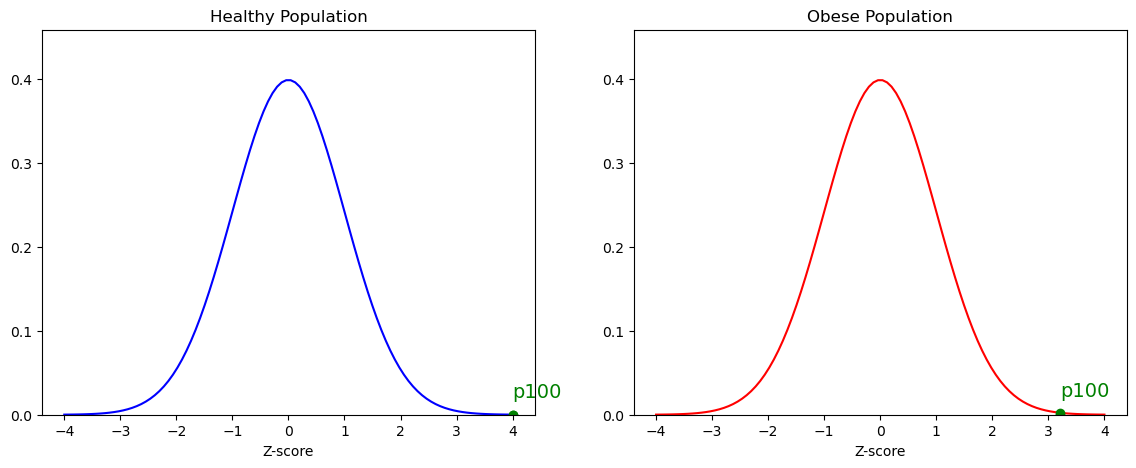

**************************************************
Risk Assessment for Metabolic Syndrome:
Metabolic Syndrome Score: 100
Lifestyle Score: 75.0
Healthy Percentile: 100.0th, Diseased Percentile: 99.99th
Metabolic Syndrome Score Distributions:


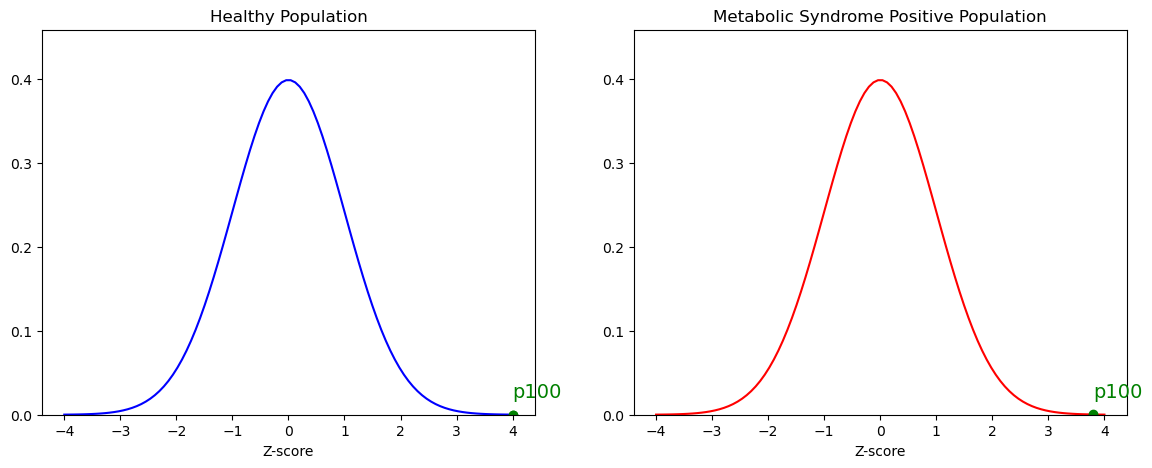

**************************************************
Risk Assessment for Diabetes(Type I):
Diabetes1 Score: 79.72
Healthy Percentile: 100.0th, Diseased Percentile: 96.9th
Diabetes(Type I) Score Distributions:


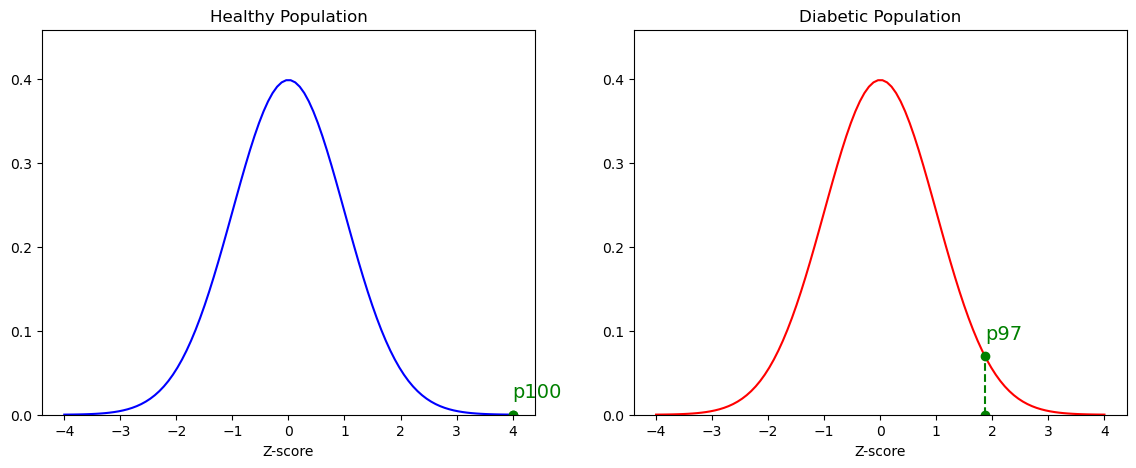

**************************************************
Risk Assessment for Diabetes(Type II):
Diabetes2 Score: 68.35
Lifestyle Score: 68.0
Healthy Percentile: 100.0th, Diseased Percentile: 97.3th
Diabetes(Type II) Score Distributions:


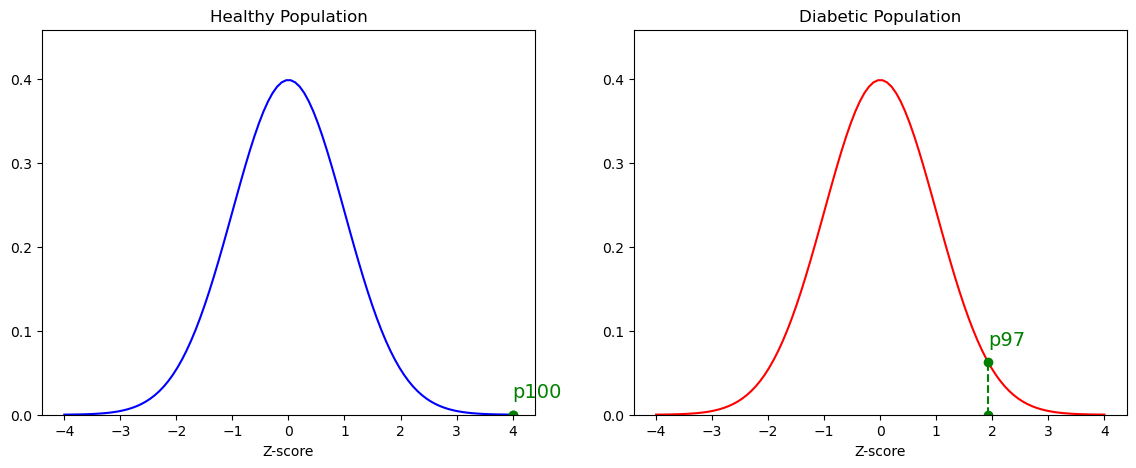

**************************************************
Risk Assessment for NAFLD:
NAFLD Score: 74.03
Lifestyle Score: 78.95
Healthy Percentile: 100.0th, Diseased Percentile: 87.96th
NAFLD Score Distributions:


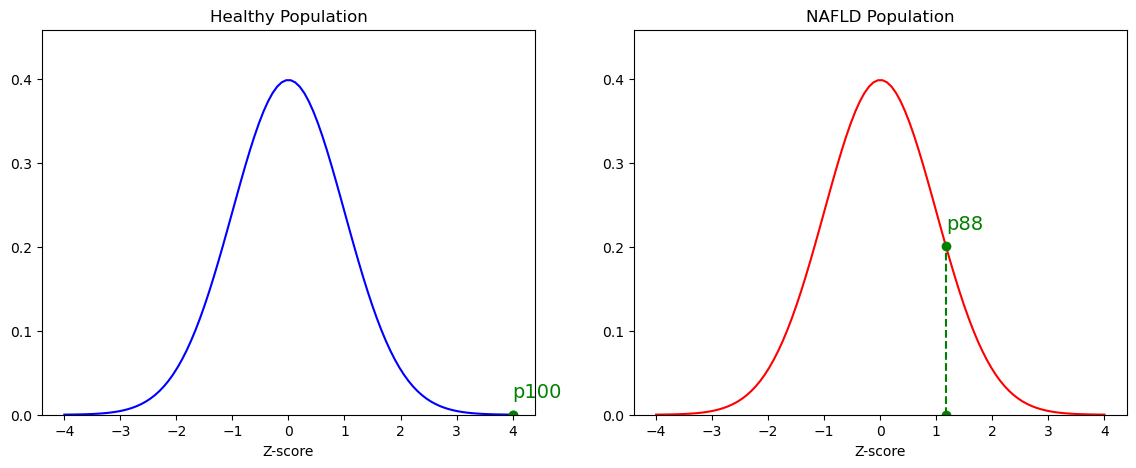

**************************************************
Risk Assessment for Cardiac Disease:
Diabetes1 Score: 93.75
Healthy Percentile: 100.0th, Diseased Percentile: 98.32th
Cardiac Score Distributions:


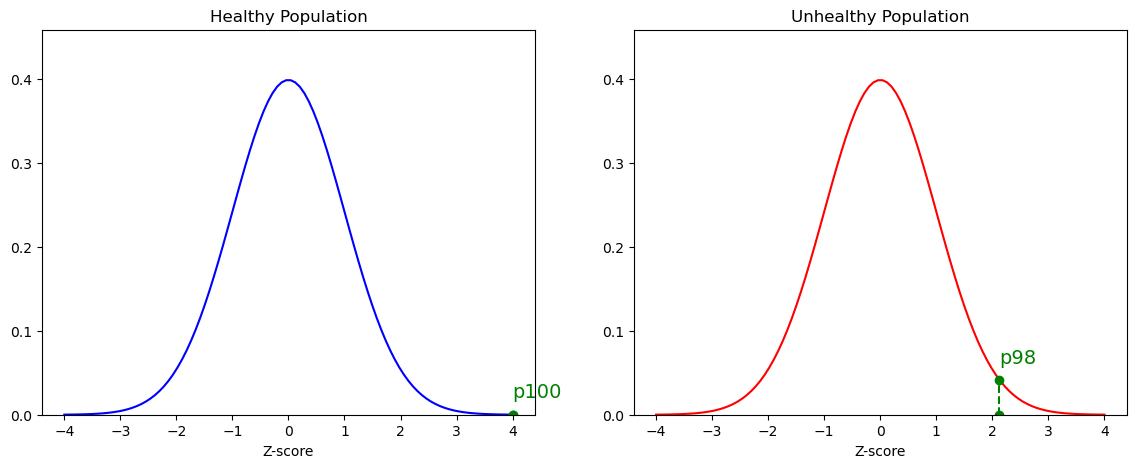

**************************************************
Risk Assessment for Hypertension:
Hypertension Score: 54.22
Lifestyle Score: 10.53
Blood Pressure Distributions:


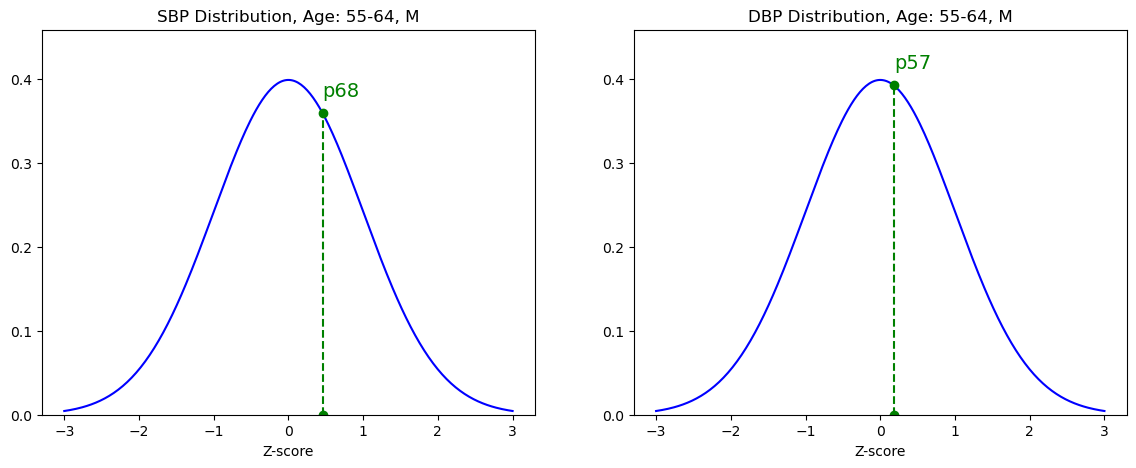

**************************************************
Risk Assessment for Dyslipidemia:
Dyslipidemia Score: 55.36
Dyslipidemia Score Distributions:


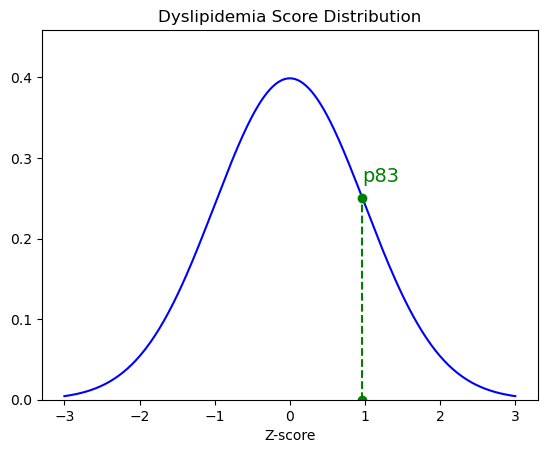

**************************************************
Risk Assessment for Hypothyroidism:
Hypothyroidism Score: 86.85
TSH Level Distributions:


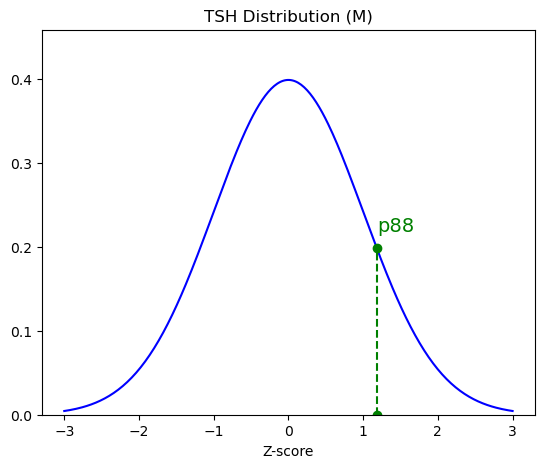

*******************************************************************************************************************
************************************************** End Of Report **************************************************
*******************************************************************************************************************


In [52]:
generate_comprehensive_report(P_II_14, questions)

In [53]:
P_I_17 = {
    'id': 'I-17',
    'sex' :'F',
    'WC' : 78,
    'TG' : 220,
    'BMI' : 30.82,
    'HDL' : 42.8,
    'age' :49,
   'glu' : 134,
    'HOMA_IR' : 4.96,
    'GGT' : 29,
    'ALT' : 24,
    'AST': 14,
    'Uric_acid': 350,
    'TC' : 246,
    'LDL' : 186,
    'SBP' : 132,
    'DBP': 80,
    'TSH' : 12.92,
    'height': 149.2,
    'BT' : 0.41,
    'LH_FSH' : 1.14
}

Patient Details:


,Values
id,I-17
sex,F
WC,78
TG,220
BMI,30.82
HDL,42.8
age,49
glu,134
HOMA_IR,3.49
GGT,29


**************************************************
Evaluating LifeStyle Scores, Please answer the following questions:
Good quality sleep
A) Between 7 to 9 hours per night
B) Between 5 to 6 hours per night
C) ≤4 or ≥9 hours per night
Your choice: a
Sedentary time
A) <1 hour per day
B) ≥1 and <4 hours per day
C) >4 hours per day
Your choice: a
Diet diversity
A) >3 food groups per day
B) < 3 food groups per day
Your choice: a
Physical activity
A) ≥60 mins per day
B) ≥30 mins per day
C) <30 mins or none per day
Your choice: a
Fruit intake
A) 1-2 per day
B) ≤2 to 3 times a week
C) Once a week or less
Your choice: a
Legume consumption
A) Everyday
B) Every alternate day
C) Not Frequent
Your choice: a
Alcohol consumption
A) <3 units/ week
B) ≥3 units / week
C) Former drinker
D) Do not drink
Your choice: a
Cigarette consumption
A) ≤2 days a month
B) ≥3 and ≤19 days a month
C) ≥20 days a month
D) Former smoker
E) Do not smoke
Your choice: a
Sugary drinks or beverages
A) ≤1 per week
B) 2-3 per w

,Marked Choice
Good quality sleep,A) Between 7 to 9 hours per night
Sedentary time,A) <1 hour per day
Diet diversity,A) >3 food groups per day
Physical activity,A) ≥60 mins per day
Fruit intake,A) 1-2 per day
Legume consumption,A) Everyday
Alcohol consumption,A) <3 units/ week
Cigarette consumption,A) ≤2 days a month
Sugary drinks or beverages,A) ≤1 per week
Breakfast frequency,A) More than 5 times a week


**************************************************
**************************************************
Comprehensive Report
Risk Assessment for Obesity:
Obesity Score: 31.05
Lifestyle Score: 0.0
Healthy Percentile: 93.09, Diseased Percentile: 42.53
Obesity Score Distributions:


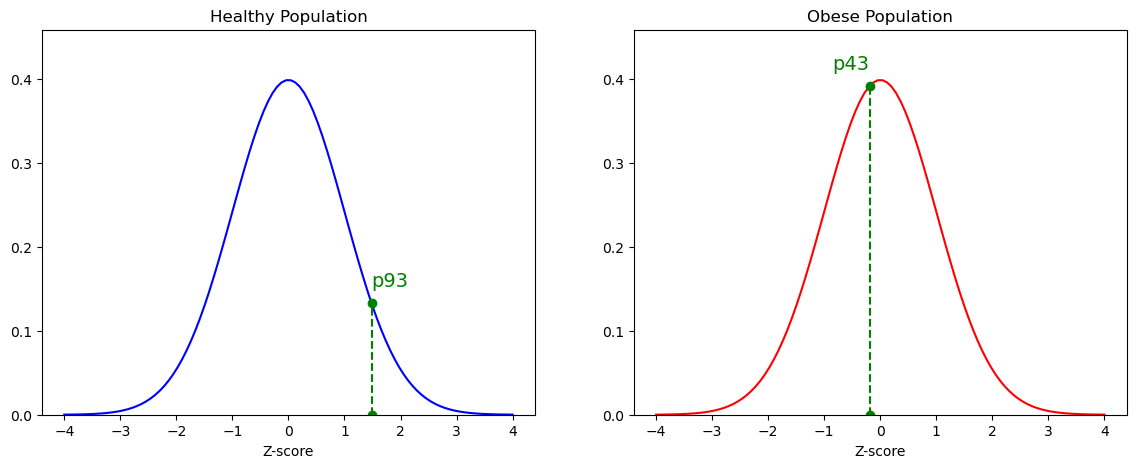

**************************************************
Risk Assessment for Metabolic Syndrome:
Metabolic Syndrome Score: 40.75
Lifestyle Score: 25.0
Healthy Percentile: 100.0th, Diseased Percentile: 66.84th
Metabolic Syndrome Score Distributions:


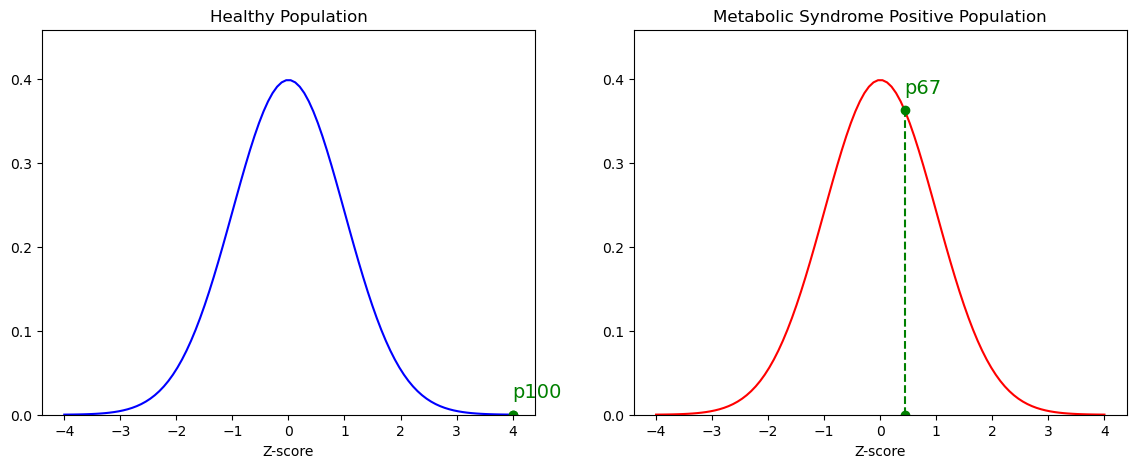

**************************************************
Risk Assessment for Diabetes(Type I):
Diabetes1 Score: 51.54
Healthy Percentile: 100.0th, Diseased Percentile: 61.32th
Diabetes(Type I) Score Distributions:


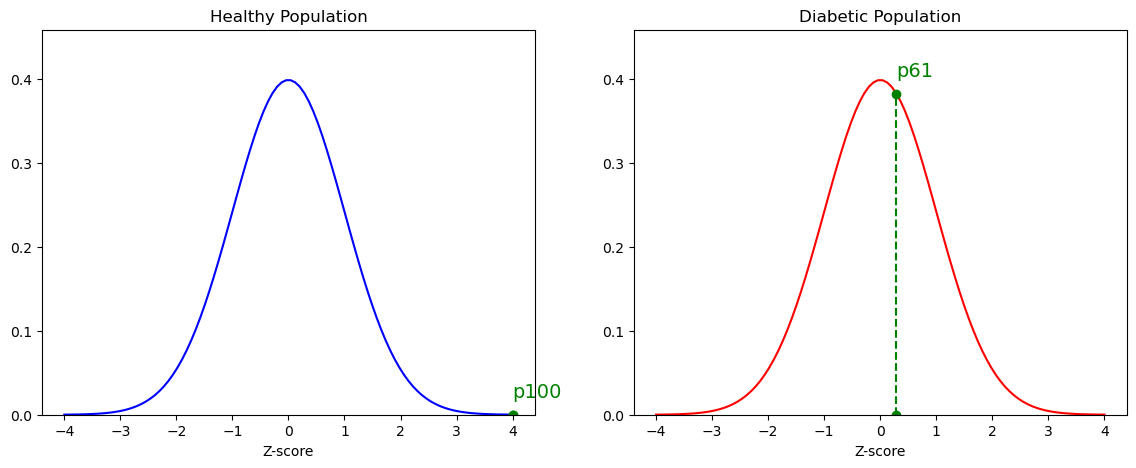

**************************************************
Risk Assessment for Diabetes(Type II):
Diabetes2 Score: 51.52
Lifestyle Score: 0.0
Healthy Percentile: 100.0th, Diseased Percentile: 74.31th
Diabetes(Type II) Score Distributions:


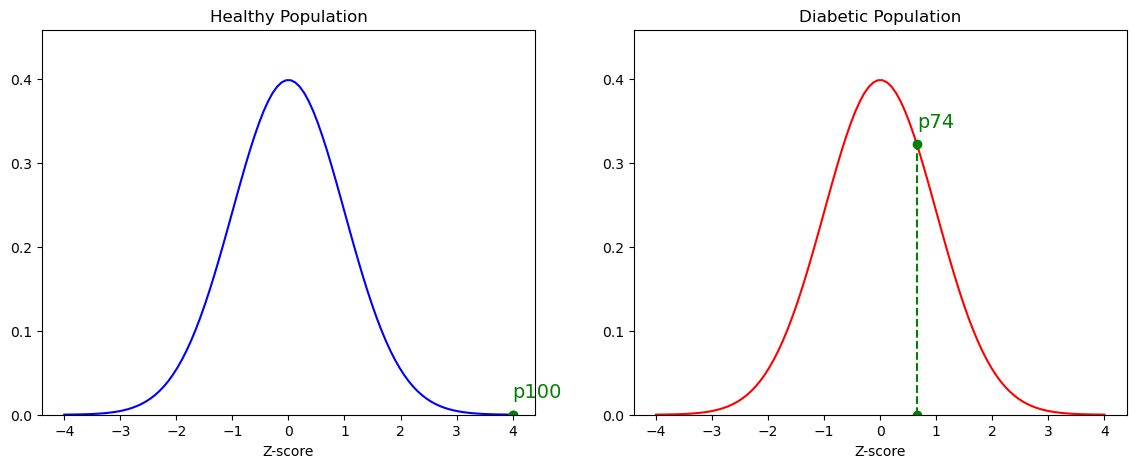

**************************************************
Risk Assessment for NAFLD:
NAFLD Score: 56.85
Lifestyle Score: 0.0
Healthy Percentile: 100.0th, Diseased Percentile: 54.07th
NAFLD Score Distributions:


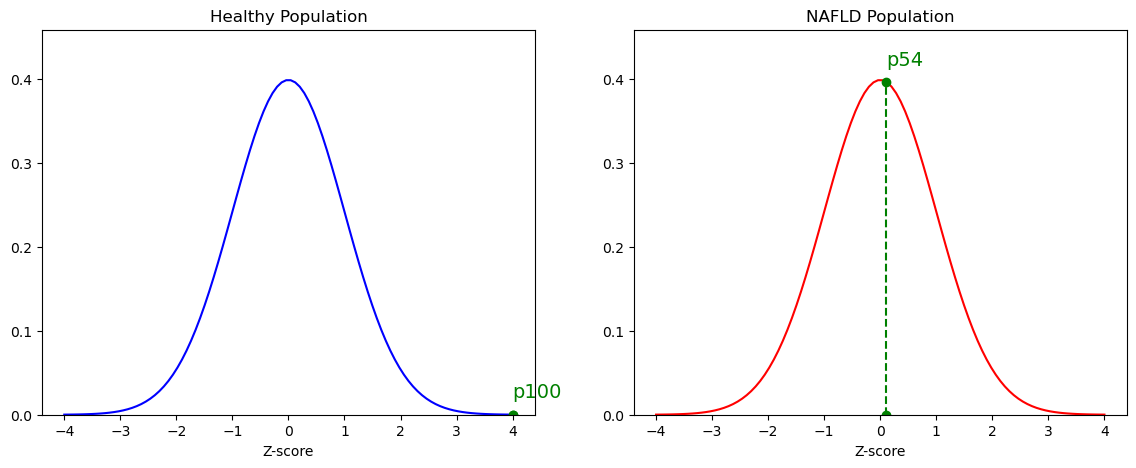

**************************************************
Risk Assessment for Cardiac Disease:
Diabetes1 Score: 73.2
Healthy Percentile: 99.75th, Diseased Percentile: 83.62th
Cardiac Score Distributions:


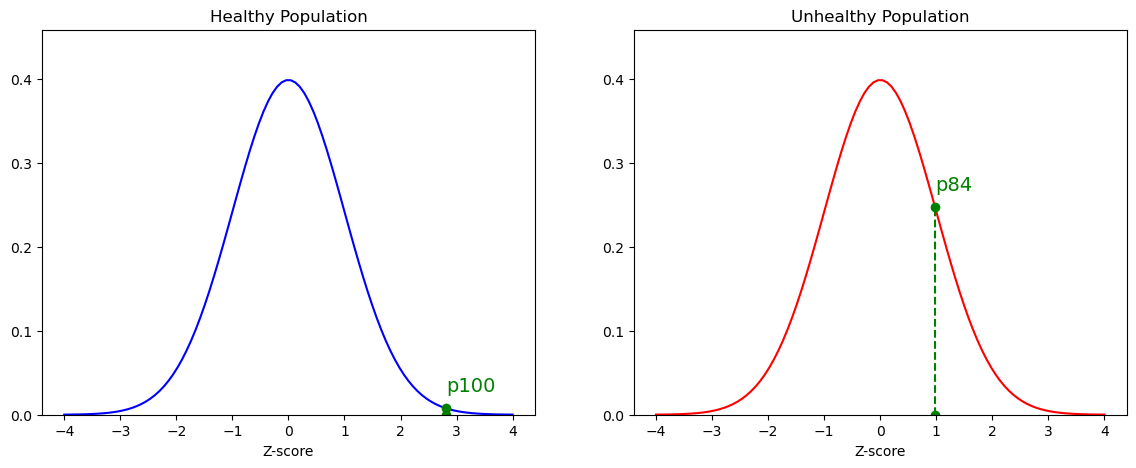

**************************************************
Risk Assessment for PCOD:
PCOD Score: 56.55
Healthy Percentile: 89.77th, Diseased Percentile: 26.24th
PCOD score Distributions:


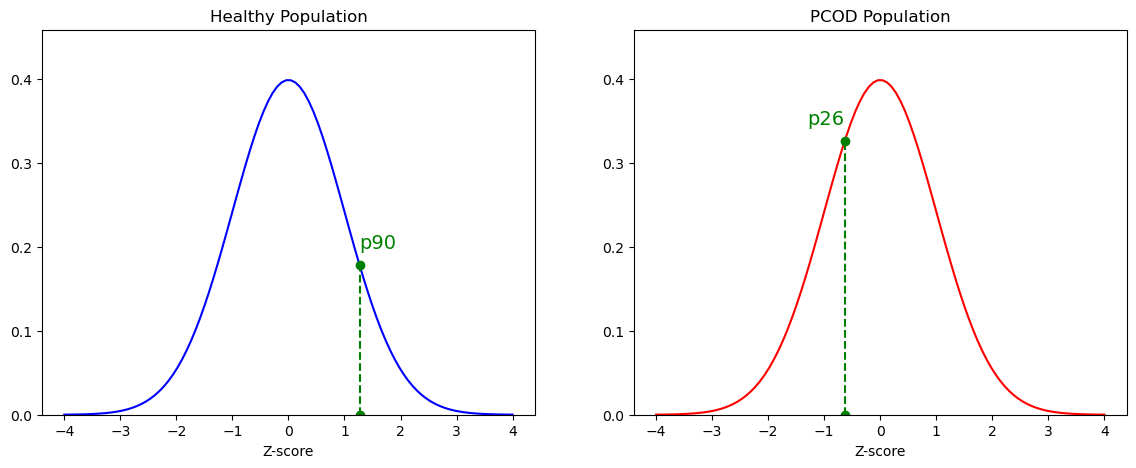

**************************************************
Risk Assessment for Hypertension:
Hypertension Score: 45.74
Lifestyle Score: 10.53
Blood Pressure Distributions:


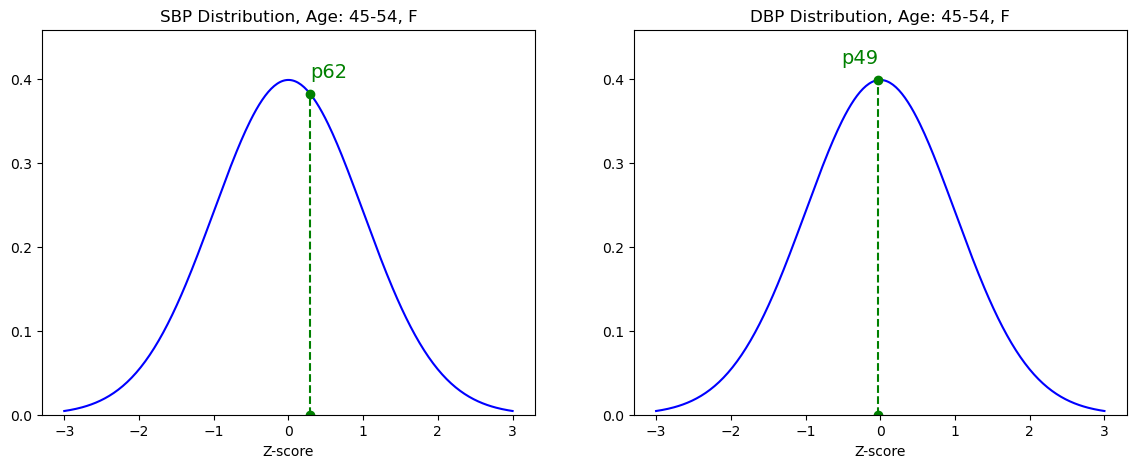

**************************************************
Risk Assessment for Dyslipidemia:
Dyslipidemia Score: 37.41
Dyslipidemia Score Distributions:


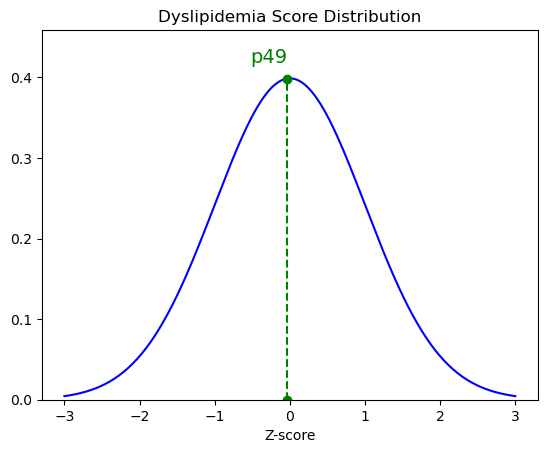

**************************************************
Risk Assessment for Hypothyroidism:
Hypothyroidism Score: 46.45
TSH Level Distributions:


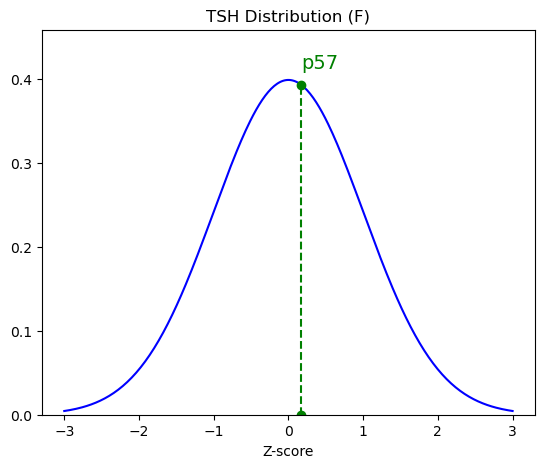

*******************************************************************************************************************
************************************************** End Of Report **************************************************
*******************************************************************************************************************


In [56]:
generate_comprehensive_report(P_I_17, questions)